# Data Cleaning Notebook for Combined PUF File - PART II

Greatly revised to solve some data problems. 

In [1]:
%matplotlib inline
import random
import math
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.rcsetup as mrc

#For standardizing variables
import sklearn.preprocessing as pre


In [2]:
cc_summary_all = pd.read_csv("/home/kylier/python/DS/data/PUF/PUF_BENE_SUMMARY_ALL.csv")

In [3]:
cc_summary_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116339 entries, 0 to 116338
Data columns (total 52 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           116339 non-null  int64  
 1   DESYNPUF_ID          116339 non-null  object 
 2   YEAR_CNT             116339 non-null  int64  
 3   MEAN_AGE             86464 non-null   float64
 4   B_SEX                116339 non-null  int64  
 5   NH_WHITE             116339 non-null  int64  
 6   AA_BLACK             116339 non-null  int64  
 7   OTHER                116339 non-null  int64  
 8   NW_HISPANIC          116339 non-null  int64  
 9   B_ALZHDMTA           116339 non-null  float64
 10  B_CHF                116339 non-null  float64
 11  B_CNCR               116339 non-null  float64
 12  B_COPD               116339 non-null  float64
 13  B_DEPRESSN           116339 non-null  float64
 14  B_DIABETES           116339 non-null  float64
 15  B_ISCHMCHT       

In [4]:
cc_summary_all.drop(columns=cc_summary_all.columns[0], axis=1, inplace=True)
cc_summary_all["FIPS_STATE_CODE"] = cc_summary_all["FIPS_STATE_CODE_x"].copy()
cc_summary_all["FIPS_COUNTY_CODE"] = cc_summary_all["FIPS_COUNTY_CODE_x"].copy()
cc_summary_all.drop(["FIPS_COUNTY_CODE_x", "FIPS_STATE_CODE_x", "FIPS_COUNTY_CODE_y", "FIPS_STATE_CODE_y"], axis=1, inplace=True)
cc_summary_all.isnull().sum() 

DESYNPUF_ID                0
YEAR_CNT                   0
MEAN_AGE               29875
B_SEX                      0
NH_WHITE                   0
AA_BLACK                   0
OTHER                      0
NW_HISPANIC                0
B_ALZHDMTA                 0
B_CHF                      0
B_CNCR                     0
B_COPD                     0
B_DEPRESSN                 0
B_DIABETES                 0
B_ISCHMCHT                 0
B_OSTEOPRS                 0
B_CHRNKIDN                 0
B_RA_OA                    0
B_STRKETIA                 0
B_ESRD                     0
MEAN_CVRG_MOS_PY           0
MEAN_RX_CVRG_MOS_PY        0
TOTAL_VISITS               0
IP_VISITS                  0
OP_VISITS                  0
MEAN_CODES_CT              0
MEAN_PROCEDURE_CT          0
MEAN_NUM_PRVDRS            0
TOTAL_INP_DAYS             0
MEAN_INP_STAY          78773
TOT_MEDREIMB_IP            0
TOT_BENRES_IP              0
TOT_PPPYMT_IP              0
TOT_MEDREIMB_OP            0
TOT_BENRES_OP 

## Checkpoint

**TO DOs:**

    Remove rows where FIPS codes are NULL
    Impute NaN ELIX TOTALS and SCORES to 0
    Impute NaN MEAN_INP_STAY to 0
    Leave NaN values alone for CBSA and MEAN_AGE
        
    REDO County Aggregation:

        Mean Age and CIs
        Prevalence of TOT_CHRONIC/BENE_COUNT
        Incidence of NEW_CHRONIC/BENE_COUNT
        Prop. Elix Sums SUM(Elix Scores)/BENE_USERS
        Costs / Beneficiary
        Covered Days Per Beneficiary
        Case Rates / Beneficiary
    
    5/29/21: ADD:
    
         # of Procedures / User
         # of Diagnoses per Claim / User
         Prop. IP Visits (County Level)

In [5]:
cc_summary_all = cc_summary_all.dropna(subset=['FIPS_STATE_CODE'])
cc_summary_all[['MEAN_ELIX_GRP_TOT', 'MEAN_ELIX_SCORE', 'MEAN_INP_STAY']] = cc_summary_all[['MEAN_ELIX_GRP_TOT', 'MEAN_ELIX_SCORE', 'MEAN_INP_STAY']].fillna(value=0)

## Beneficiary Count & User Count

There are a total of 114,530 beneficiaries represented for the years 2008-2010.

There are a total of 85,524 with 1 or more visits (Users).

In [6]:
cc_summary_all.shape

(114530, 49)

In [7]:
cc_summary_all[cc_summary_all["TOTAL_VISITS"]>0].shape

(85524, 49)

## Beneficiary Distribution by State & County

<AxesSubplot:xlabel='DESYNPUF_ID', ylabel='Count'>

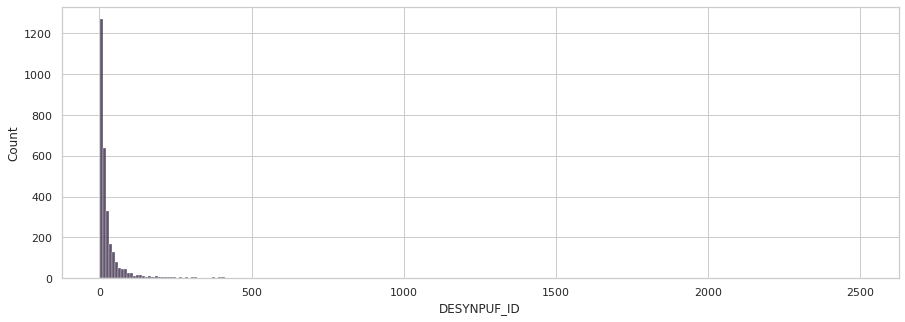

In [8]:
sb.set(rc={"figure.figsize":(15, 5)})
sb.set_theme(style="whitegrid", palette="mako")
sb.histplot(x=cc_summary_all.groupby(["FIPS_STATE_CODE","FIPS_COUNTY_CODE"])["DESYNPUF_ID"].count(), binwidth=10)

## User Distribution by State and County

Beneficiaries with Visits > 0

<AxesSubplot:xlabel='DESYNPUF_ID', ylabel='Count'>

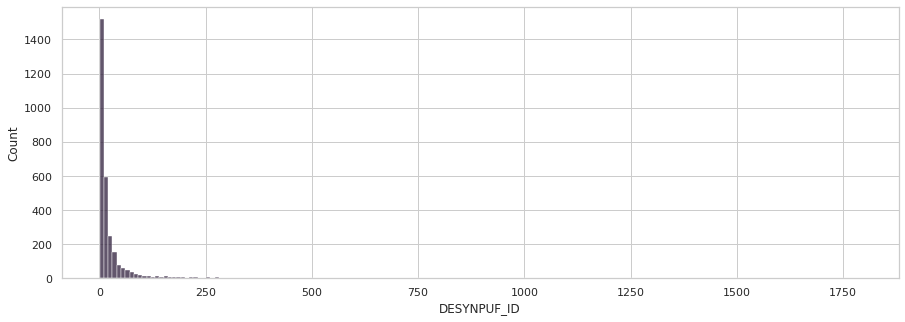

In [9]:
c = cc_summary_all[cc_summary_all["TOTAL_VISITS"]>0]

sb.set(rc={"figure.figsize":(15, 5)})
sb.set_theme(style="whitegrid", palette="mako")
sb.histplot(x=c.groupby(["FIPS_STATE_CODE","FIPS_COUNTY_CODE"])["DESYNPUF_ID"].count(), binwidth=10)

## Users with > 3 Visits By State and County

61,000 out of 85,524 have > 3 visits.

5,419 users have > 3 but < 5 visits.

4,198 users have > 5 but < 7 visits.

3,708 users have > 7 but < 9 visits.

6,528 users have > 9 but < 12 visits.

5,288 users have > 12 but < 15 visits.

6,933 users have > 15 but < 20 visits.

4,074 users have > 20 but < 25 visits.

5,079 users have > 25 visits over the three year period.

<AxesSubplot:xlabel='DESYNPUF_ID', ylabel='Count'>

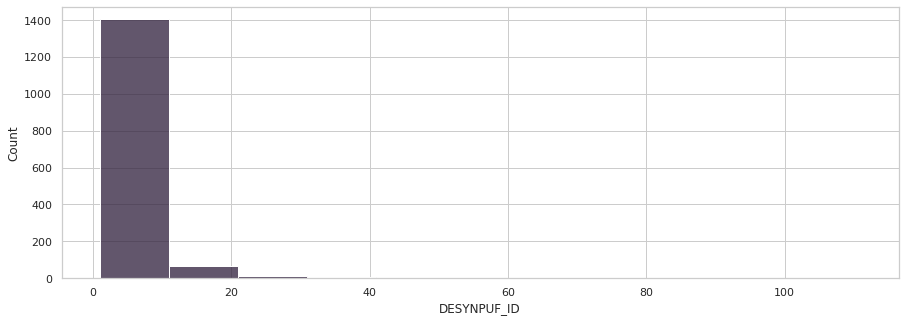

In [10]:
cc = cc_summary_all[cc_summary_all["TOTAL_VISITS"]>25]

sb.set(rc={"figure.figsize":(15, 5)})
sb.set_theme(style="whitegrid", palette="mako")
sb.histplot(x=cc.groupby(["FIPS_STATE_CODE","FIPS_COUNTY_CODE"])["DESYNPUF_ID"].count(), binwidth=10)

### Once you get past 40 visits, there are fewer and fewer "super utilizers" in that category.

The max visits is 60, but very very few beneficiaries had > 50 visits.

In [11]:
cc_summary_all["TOTAL_VISITS"].describe()

count    114530.00000
mean          7.29043
std           8.37808
min           0.00000
25%           0.00000
50%           4.00000
75%          12.00000
max          60.00000
Name: TOTAL_VISITS, dtype: float64

In [12]:
# Removing those beneficiaries with > 40 visits (about 350 rows)

cc_summary_all = cc_summary_all[cc_summary_all["TOTAL_VISITS"]<41]
cc_summary_all["TOTAL_VISITS"].describe()

count    114182.000000
mean          7.177804
std           8.136110
min           0.000000
25%           0.000000
50%           4.000000
75%          12.000000
max          40.000000
Name: TOTAL_VISITS, dtype: float64

## Beneficiary Count & User Counts After Outlier Removal

There are now a total of 114,182 beneficiaries represented for the years 2008-2010.

And there are a total of 85,176 with 1 or more visits (Users).

The maximum number of visits is 40.

In [13]:
cc_summary_all.shape

(114182, 49)

In [14]:
cc_summary_all[cc_summary_all["TOTAL_VISITS"]>0].shape

(85176, 49)

## The Power of the Elixhauser Score

The below correlation matrix shows that the Elixhauser Score has some ability to represent patients' chronic conditions burdens, but it isn't perfect.  The TOTCHRONIC variable is a bit better in this regard, so we should use both of these measures to help us to represent severity of disease.

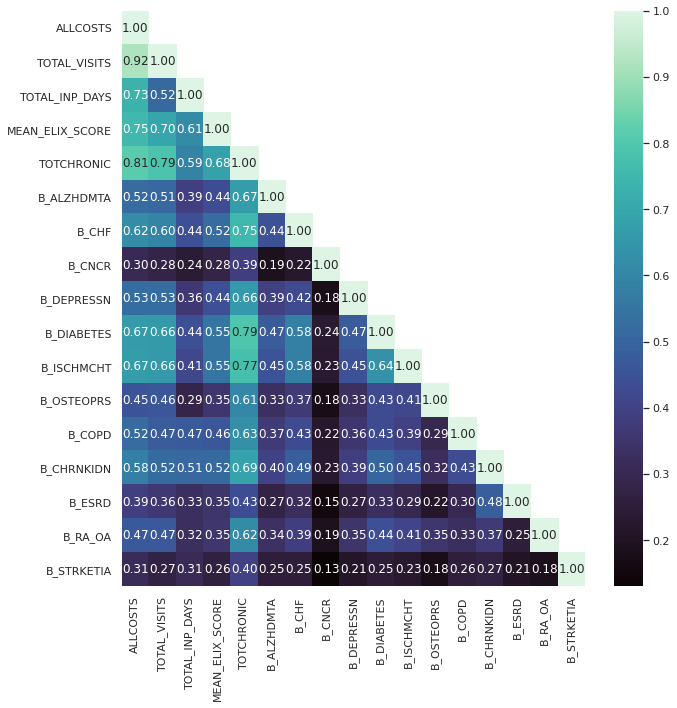

In [15]:
cost_ed_conds = cc_summary_all[["ALLCOSTS", "TOTAL_VISITS", "TOTAL_INP_DAYS", "MEAN_ELIX_SCORE",
                                "TOTCHRONIC", "B_ALZHDMTA", "B_CHF", "B_CNCR", "B_DEPRESSN", "B_DIABETES", 
                                "B_ISCHMCHT", "B_OSTEOPRS", "B_COPD", "B_CHRNKIDN", "B_ESRD",
                                "B_RA_OA", "B_STRKETIA"]]
cost_ed_corr = cost_ed_conds.corr(method="spearman")
lr_cost_ed_corr = cost_ed_corr.where(np.tril(np.ones(cost_ed_corr.shape)).astype(np.bool))

plt.rcParams["figure.figsize"] = (10.0, 10.0)
cost_ed_hmap=sb.heatmap(lr_cost_ed_corr, annot=True, cmap="mako", fmt=".2f")
fig = cost_ed_hmap.get_figure()
fig.tight_layout()
fig.savefig("cost_desynpuf_conditions_heatmap.png")

## Keeping Some Variables

In light of this, I will keep the following disease-specific variables, and aggregate them to their county-level prevalence rates: B_CNCR, B_ESRD, and B_STRKETIA.

I will drop the other disease-specific variables, since I believe that Elixhauser plus TOTCHRONIC do a good-enough job of representing their impact.

In [16]:
cc_summary_all.drop(["B_ALZHDMTA", "B_CHF", "B_DEPRESSN", "B_DIABETES", "B_ISCHMCHT", "B_CHRNKIDN", 
                     "B_OSTEOPRS", "B_COPD", "B_RA_OA"], axis=1, inplace=True, errors="ignore")

# Also drop columns used to compute Inpatient and Outpatient costs, since we already have sums.
cc_summary_all.drop(["TOT_MEDREIMB_IP",  "TOT_BENRES_IP", "TOT_PPPYMT_IP", "TOT_MEDREIMB_OP", "TOT_BENRES_OP", 
                     "TOT_PPPYMT_OP"], axis=1, inplace=True, errors="ignore")
cc_summary_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114182 entries, 0 to 116338
Data columns (total 34 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   DESYNPUF_ID          114182 non-null  object 
 1   YEAR_CNT             114182 non-null  int64  
 2   MEAN_AGE             85176 non-null   float64
 3   B_SEX                114182 non-null  int64  
 4   NH_WHITE             114182 non-null  int64  
 5   AA_BLACK             114182 non-null  int64  
 6   OTHER                114182 non-null  int64  
 7   NW_HISPANIC          114182 non-null  int64  
 8   B_CNCR               114182 non-null  float64
 9   B_STRKETIA           114182 non-null  float64
 10  B_ESRD               114182 non-null  float64
 11  MEAN_CVRG_MOS_PY     114182 non-null  float64
 12  MEAN_RX_CVRG_MOS_PY  114182 non-null  float64
 13  TOTAL_VISITS         114182 non-null  int64  
 14  IP_VISITS            114182 non-null  int64  
 15  OP_VISITS        

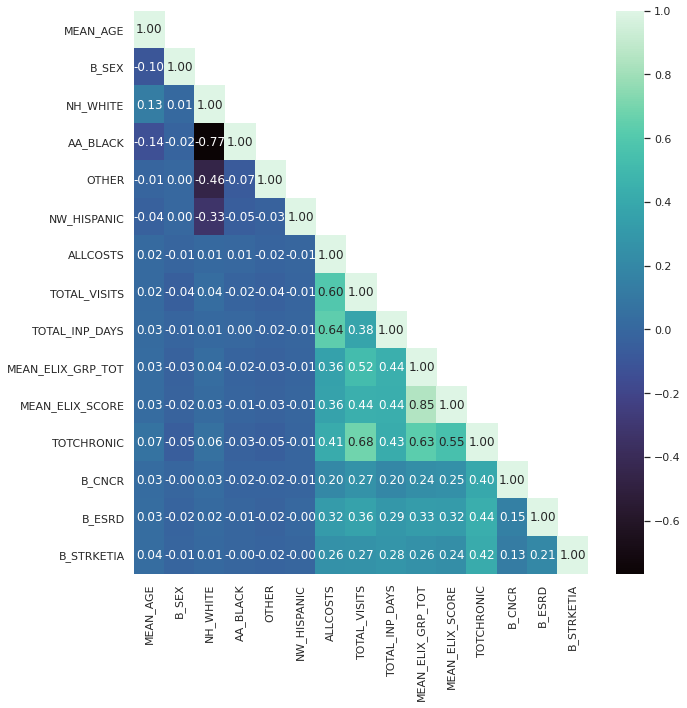

In [17]:
final_corr = cc_summary_all[["MEAN_AGE", "B_SEX", "NH_WHITE", "AA_BLACK", "OTHER", "NW_HISPANIC", 
                             "ALLCOSTS", "TOTAL_VISITS", "TOTAL_INP_DAYS", "MEAN_ELIX_GRP_TOT", "MEAN_ELIX_SCORE",
                             "TOTCHRONIC", "B_CNCR", "B_ESRD", "B_STRKETIA"]]
f_corr = final_corr.corr(method="pearson")
lr_f_corr = f_corr.where(np.tril(np.ones(f_corr.shape)).astype(np.bool))

plt.rcParams["figure.figsize"] = (10.0, 10.0)
f_corr_hmap=sb.heatmap(lr_f_corr, annot=True, cmap="mako", fmt=".2f")
fig = f_corr_hmap.get_figure()
fig.tight_layout()
fig.savefig("f_corr_heatmap.png")

## All Things Considered,

These variables show a decent amount of independence.  The model coefficients should be *very* interesting!!

NOTE: Because MEAN_ELIX_GRP_TOT and MEAN_ELIX_SCORE are 85% correlated, I will keep MEAN_ELIX_SCORE only.

In [18]:
# Setting up for aggregation.

cc_summary3 = cc_summary_all.copy()
cc_summary3.reset_index(inplace=True)
cc_summary3

,index,DESYNPUF_ID,YEAR_CNT,MEAN_AGE,B_SEX,NH_WHITE,AA_BLACK,OTHER,NW_HISPANIC,B_CNCR,...,ALLCOSTS,NEW_CHRONIC,TOTCHRONIC,VISITS_FLAG,PERCENT_COSTS,MEAN_ELIX_GRP_TOT,MEAN_ELIX_SCORE,IP_VISIT_PROP,FIPS_STATE_CODE,FIPS_COUNTY_CODE
0,0,0000438E79D01BEA,3,NaN,1,1,0,0,0,0.0,...,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.00,12.0,57.0
1,1,00010E7BEA69142C,2,71.0,0,1,0,0,0,0.0,...,1620.0,0.0,2.0,1,0.000022,0.333333,0.500000,0.00,10.0,3.0
2,2,00015BF6509E1DF7,3,75.1,0,1,0,0,0,0.0,...,25860.0,3.0,7.0,1,0.000356,0.555556,0.555556,0.00,37.0,119.0
3,3,00018DD17736A661,1,73.0,0,1,0,0,0,0.0,...,6930.0,0.0,2.0,1,0.000095,0.428571,1.571429,0.00,26.0,101.0
4,4,000240D599ED789C,3,67.0,0,0,1,0,0,0.0,...,509056.0,5.0,6.0,1,0.007014,0.766667,2.016667,0.15,55.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114177,116334,FFFDFD377BF9EC59,3,NaN,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.00,41.0,11.0
114178,116335,FFFF1E240FFD97D8,3,NaN,0,1,0,0,0,0.0,...,0.0,0.0,0.0,0,0.000000,0.000000,0.000000,0.00,27.0,19.0
114179,116336,FFFF58406F9882DD,3,69.0,1,1,0,0,0,0.0,...,1230.0,4.0,7.0,1,0.000017,0.555556,3.333333,0.00,48.0,469.0
114180,116337,FFFFCA5AFABA1CF6,1,69.0,1,0,1,0,0,0.0,...,1100.0,0.0,6.0,1,0.000015,1.500000,2.500000,0.00,51.0,59.0


In [19]:
cc_county = cc_summary3.groupby(["FIPS_STATE_CODE", "FIPS_COUNTY_CODE"]).aggregate({"DESYNPUF_ID":"count",
                                                                                    "VISITS_FLAG":"sum",
                                                                                    "MEAN_AGE": ["mean","std","count"],
                                                                                    "B_SEX":"mean",
                                                                                    "NH_WHITE":"sum",
                                                                                    "AA_BLACK":"sum",
                                                                                    "OTHER":"sum",
                                                                                    "NW_HISPANIC":"sum",
                                                                                    "B_CNCR":"sum",
                                                                                    "B_STRKETIA":"sum",
                                                                                    "B_ESRD":"sum",
                                                                                    "MEAN_CVRG_MOS_PY":"sum",
                                                                                    "MEAN_RX_CVRG_MOS_PY":"sum",
                                                                                    "TOTAL_VISITS":"sum",
                                                                                    "IP_VISITS":"sum",
                                                                                    "OP_VISITS":"sum",
                                                                                    "MEAN_CODES_CT":"sum",
                                                                                    "MEAN_PROCEDURE_CT":"sum",
                                                                                    "MEAN_NUM_PRVDRS":"sum",
                                                                                    "TOTAL_INP_DAYS":"sum",
                                                                                    "MEAN_INP_STAY":"mean",
                                                                                    "CBSA":"mean",
                                                                                    "TOTCHRONIC":["sum","mean"],
                                                                                    "NEW_CHRONIC":["sum","mean"],
                                                                                    "MEAN_ELIX_SCORE":"sum",
                                                                                    "TOTIPCOST":"sum",
                                                                                    "TOTOPCOST":"sum",
                                                                                    "ALLCOSTS":"sum"})


cc_county.columns = ["CNTY_BENE_CT", "CNTY_BENE_USRS", "CNTY_MEAN_AGE", "AGE_STD", "AGE_N", 
                     "CNTY_SEX_PROP", "NH_WHITE_N", "AA_BLACK_N", "OTHER_N", "NW_HISPANIC_N",
                     "TOT_CNCR_CASES", "TOT_STRKETIA_CASES", "TOT_ESRD_CASES", 
                     "TOT_CVRG_MOS_PY", "TOT_RX_CVRG_MOS_PY","CNTY_TOT_VSTS", "CNTY_TOT_IP_VSTS", 
                     "CNTY_TOT_OP_VSTS", "CNTY_TOT_CODES", "CNTY_TOT_PROCS", "CNTY_TOT_PRVDRS", 
                     "CNTY_TOT_IP_DAYS", "CNTY_MEAN_IP_STAY", "CBSA", "CNTY_TOT_CCS", "CNTY_MEAN_CCS", 
                     "CNTY_TOT_NEW_CCS", "CNTY_MEAN_NEW_CCS", "CNTY_SUM_ELIX_SCORES", "CNTY_TOT_IP_COST",
                     "CNTY_TOT_OP_COST", "CNTY_ALL_COSTS"]

ALL_TOTALS = cc_county["CNTY_ALL_COSTS"].sum()
cc_county["CNTY_PERCENT_COSTS"] = cc_county["CNTY_ALL_COSTS"] / ALL_TOTALS * 100
cc_county["CNTY_USR_PROP"] = cc_county["CNTY_BENE_USRS"]/cc_county["CNTY_BENE_CT"]
cc_county["CNTY_IP_PROP"] = cc_county["CNTY_TOT_IP_VSTS"]/cc_county["CNTY_TOT_VSTS"]


In [20]:
cc_county["CNTY_MEAN_AGE"] = cc_county["CNTY_MEAN_AGE"].round(decimals=1)
cc_county["CNTY_AGE_95CIL"] = cc_county["CNTY_MEAN_AGE"]-(1.96*(cc_county["AGE_STD"]/np.sqrt(cc_county["AGE_N"])))
cc_county["CNTY_AGE_95CIU"] = cc_county["CNTY_MEAN_AGE"]+(1.96*(cc_county["AGE_STD"]/np.sqrt(cc_county["AGE_N"])))

In [21]:
cc_county["CNTY_PROP_NH_WHITE"] = cc_county["NH_WHITE_N"]/cc_county["CNTY_BENE_CT"]
cc_county["CNTY_PROP_AA_BLACK"] = cc_county["AA_BLACK_N"]/cc_county["CNTY_BENE_CT"]
cc_county["CNTY_PROP_OTHER"] = cc_county["OTHER_N"]/cc_county["CNTY_BENE_CT"]
cc_county["CNTY_PROP_NW_HISPANIC"] = cc_county["NW_HISPANIC_N"]/cc_county["CNTY_BENE_CT"]

In [22]:
cc_county["TOT_CNCR_PREV"] = cc_county["TOT_CNCR_CASES"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_STRK_PREV"] = cc_county["TOT_STRKETIA_CASES"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_ESRD_PREV"] = cc_county["TOT_ESRD_CASES"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_CVRG_MOS_PB_PY"] = cc_county["TOT_CVRG_MOS_PY"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_RXCVRG_MOS_PB_PY"] = cc_county["TOT_RX_CVRG_MOS_PY"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_VSTS_PB"] = cc_county["CNTY_TOT_VSTS"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_VSTS_PU"] = cc_county["CNTY_TOT_VSTS"]/cc_county["CNTY_BENE_USRS"]
cc_county["TOT_IP_VSTS_PU"] = cc_county["CNTY_TOT_IP_VSTS"]/cc_county["CNTY_BENE_USRS"]
cc_county["TOT_OP_VSTS_PU"] = cc_county["CNTY_TOT_OP_VSTS"]/cc_county["CNTY_BENE_USRS"]
cc_county["CODES_PU"] = cc_county["CNTY_TOT_CODES"]/cc_county["CNTY_BENE_USRS"]
cc_county["PROCS_PU"] = cc_county["CNTY_TOT_PROCS"]/cc_county["CNTY_BENE_USRS"]
cc_county["PRVDRS_PU"] = cc_county["CNTY_TOT_PRVDRS"]/cc_county["CNTY_BENE_USRS"]
cc_county["TOT_IPDAYS_PU"] = cc_county["CNTY_TOT_IP_DAYS"]/cc_county["CNTY_BENE_USRS"]
cc_county["TOT_CC_PREV"] = cc_county["CNTY_TOT_CCS"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_CCS_PU"] = cc_county["CNTY_TOT_CCS"]/cc_county["CNTY_BENE_USRS"]
cc_county["TOT_CC_INCD"] = cc_county["CNTY_TOT_NEW_CCS"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_NEW_CC_PU"] = cc_county["CNTY_TOT_NEW_CCS"]/cc_county["CNTY_BENE_USRS"]
cc_county["TOT_ELIX_PU"] = cc_county["CNTY_SUM_ELIX_SCORES"]/cc_county["CNTY_BENE_USRS"]
cc_county["TOT_IP_COST_PB"] = cc_county["CNTY_TOT_IP_COST"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_OP_COST_PB"] = cc_county["CNTY_TOT_OP_COST"]/cc_county["CNTY_BENE_CT"]
cc_county["TOT_COST_PB"] = cc_county["CNTY_ALL_COSTS"]/cc_county["CNTY_BENE_CT"]

In [23]:
cc_county

CNTY_BENE_CT  CNTY_BENE_USRS  CNTY_MEAN_AGE  \
FIPS_STATE_CODE FIPS_COUNTY_CODE                                                
1.0             1.0                         16              13           65.4   
                3.0                         95              65           70.3   
                5.0                         14              12           72.4   
                7.0                         17              12           69.0   
                9.0                         22              12           68.8   
...                                        ...             ...            ...   
56.0            37.0                        34              17           72.9   
                39.0                        13               5           70.5   
                41.0                        18               6           72.0   
                43.0                         8               0            NaN   
                45.0                        15               2           75.5   

                                    AGE_STD  AGE_N  CNTY_SEX_PROP  NH_WHITE_N  \
FIPS_STATE_CODE FIPS_COUNTY_CODE                                                
1.0             1.0               19.365814     13       0.187500          11   
                3.0               12.226355     65       0.463158          60   
                5.0               14.223165     12       0.642857           7   
                7.0               15.493427     12       0.411765          12   
                9.0               18.347496     12       0.636364          13   
...                                     ...    ...            ...         ...   
56.0            37.0               6.450376     17       0.529412          34   
                39.0               7.194303      5       0.538462          13   
                41.0              11.516206      6       0.500000          17   
                43.0                    NaN      0       0.625000           8   
                45.0               6.363961      2       0.600000          15   

                                  AA_BLACK_N  OTHER_N  NW_HISPANIC_N  ...  \
FIPS_STATE_CODE FIPS_COUNTY_CODE                                      ...   
1.0             1.0                        5        0              0  ...   
                3.0                       34        1              0  ...   
                5.0                        7        0              0  ...   
                7.0                        5        0              0  ...   
                9.0                        9        0              0  ...   
...                                      ...      ...            ...  ...   
56.0            37.0                       0        0              0  ...   
                39.0                       0        0              0  ...   
                41.0                       0        1              0  ...   
                43.0                       0        0              0  ...   
                45.0                       0        0              0  ...   

                                  PRVDRS_PU  TOT_IPDAYS_PU  TOT_CC_PREV  \
FIPS_STATE_CODE FIPS_COUNTY_CODE                                          
1.0             1.0                2.307692       3.692308     4.937500   
                3.0                3.297436       5.615385     3.747368   
                5.0                1.888889       4.833333     3.500000   
                7.0                2.833333       4.666667     4.470588   
                9.0                1.555556       5.500000     2.181818   
...                                     ...            ...          ...   
56.0            37.0               1.254902       2.647059     2.558824   
                39.0               1.266667       0.600000     1.769231   
                41.0               1.444444       0.000000     1.611111   
                43.0                    NaN            NaN     0.000000   
                45.0    

In [24]:
cc_county["CNTY_BENE_CT"].describe()

count    3010.000000
mean       37.934219
std        94.595933
min         1.000000
25%         6.000000
50%        13.000000
75%        32.000000
max      2488.000000
Name: CNTY_BENE_CT, dtype: float64

## Representative Counties

So, if we remove the counties with fewer than 50 beneficiaries, we have 490 counties.

If we remove those with fewer than 30, we have 811 counties.

There are 121 counties with ONE beneficiary.

There are 693 counties with 5 OR FEWER beneficiaries, and 1267 counties with 10 OR FEWER.

As we discussed I am going to leave all the counties here.  But we may choose to exclude some later, as we analyze.

In [25]:
cc_county.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3010 entries, (1.0, 1.0) to (56.0, 45.0)
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CNTY_BENE_CT           3010 non-null   int64  
 1   CNTY_BENE_USRS         3010 non-null   int64  
 2   CNTY_MEAN_AGE          2957 non-null   float64
 3   AGE_STD                2766 non-null   float64
 4   AGE_N                  3010 non-null   int64  
 5   CNTY_SEX_PROP          3010 non-null   float64
 6   NH_WHITE_N             3010 non-null   int64  
 7   AA_BLACK_N             3010 non-null   int64  
 8   OTHER_N                3010 non-null   int64  
 9   NW_HISPANIC_N          3010 non-null   int64  
 10  TOT_CNCR_CASES         3010 non-null   float64
 11  TOT_STRKETIA_CASES     3010 non-null   float64
 12  TOT_ESRD_CASES         3010 non-null   float64
 13  TOT_CVRG_MOS_PY        3010 non-null   float64
 14  TOT_RX_CVRG_MOS_PY     3010 non-null   

## Checking Calculated Fields

In [26]:
cc_county[["CNTY_MEAN_AGE", "CNTY_AGE_95CIL", "CNTY_AGE_95CIU"]]

CNTY_MEAN_AGE  CNTY_AGE_95CIL  \
FIPS_STATE_CODE FIPS_COUNTY_CODE                                  
1.0             1.0                        65.4       54.872624   
                3.0                        70.3       67.327674   
                5.0                        72.4       64.352487   
                7.0                        69.0       60.233768   
                9.0                        68.8       58.418927   
...                                         ...             ...   
56.0            37.0                       72.9       69.833686   
                39.0                       70.5       64.193915   
                41.0                       72.0       62.785116   
                43.0                        NaN             NaN   
                45.0                       75.5       66.680000   

                                  CNTY_AGE_95CIU  
FIPS_STATE_CODE FIPS_COUNTY_CODE                  
1.0             1.0                    75.927376  
                3.0                    73.272326  
                5.0                    80.447513  
                7.0                    77.766232  
                9.0                    79.181073  
...                                          ...  
56.0            37.0                   75.966314  
                39.0                   76.806085  
                41.0                   81.214884  
                43.0                         NaN  
                45.0                   84.320000  

[3010 rows x 3 columns]

In [27]:
cc_county[["CNTY_PROP_NH_WHITE", "CNTY_PROP_AA_BLACK", "CNTY_PROP_OTHER", "CNTY_PROP_NW_HISPANIC"]]

CNTY_PROP_NH_WHITE  CNTY_PROP_AA_BLACK  \
FIPS_STATE_CODE FIPS_COUNTY_CODE                                           
1.0             1.0                         0.687500            0.312500   
                3.0                         0.631579            0.357895   
                5.0                         0.500000            0.500000   
                7.0                         0.705882            0.294118   
                9.0                         0.590909            0.409091   
...                                              ...                 ...   
56.0            37.0                        1.000000            0.000000   
                39.0                        1.000000            0.000000   
                41.0                        0.944444            0.000000   
                43.0                        1.000000            0.000000   
                45.0                        1.000000            0.000000   

                                  CNTY_PROP_OTHER  CNTY_PROP_NW_HISPANIC  
FIPS_STATE_CODE FIPS_COUNTY_CODE                                          
1.0             1.0                      0.000000                    0.0  
                3.0                      0.010526                    0.0  
                5.0                      0.000000                    0.0  
                7.0                      0.000000                    0.0  
                9.0                      0.000000                    0.0  
...                                           ...                    ...  
56.0            37.0                     0.000000                    0.0  
                39.0                     0.000000                    0.0  
                41.0                     0.055556                    0.0  
                43.0                     0.000000                    0.0  
                45.0                     0.000000                    0.0  

[3010 rows x 4 columns]

In [28]:
cc_county[["CNTY_TOT_VSTS", "TOT_VSTS_PB", "TOT_VSTS_PU"]]

CNTY_TOT_VSTS  TOT_VSTS_PB  TOT_VSTS_PU
FIPS_STATE_CODE FIPS_COUNTY_CODE                                         
1.0             1.0                         112     7.000000     8.615385
                3.0                         720     7.578947    11.076923
                5.0                          92     6.571429     7.666667
                7.0                         152     8.941176    12.666667
                9.0                          86     3.909091     7.166667
...                                         ...          ...          ...
56.0            37.0                        138     4.058824     8.117647
                39.0                         38     2.923077     7.600000
                41.0                         61     3.388889    10.166667
                43.0                          0     0.000000          NaN
                45.0                          2     0.133333     1.000000

[3010 rows x 3 columns]

In [29]:
# Dropping columns that were used for calculations that are no longer needed.

cc_county.drop(["AGE_STD", "AGE_N", "NH_WHITE_N", "AA_BLACK_N", "OTHER_N", "NW_HISPANIC_N", 
               "TOT_CVRG_MOS_PY", "TOT_RX_CVRG_MOS_PY", "CNTY_TOT_PRVDRS", "CNTY_TOT_IP_DAYS"], axis=1, inplace=True, errors="ignore")

In [30]:
cc_county.shape

(3010, 52)

In [31]:
cc_county = cc_county.reset_index()
cc_county

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,PRVDRS_PU,TOT_IPDAYS_PU,TOT_CC_PREV,TOT_CCS_PU,TOT_CC_INCD,TOT_NEW_CC_PU,TOT_ELIX_PU,TOT_IP_COST_PB,TOT_OP_COST_PB,TOT_COST_PB
0,1.0,1.0,16,13,65.4,0.187500,3.0,3.0,5.0,112,...,2.307692,3.692308,4.937500,6.076923,2.562500,3.153846,1.492308,33386.750000,11793.125000,45179.875000
1,1.0,3.0,95,65,70.3,0.463158,18.0,8.0,18.0,720,...,3.297436,5.615385,3.747368,5.476923,1.705263,2.492308,1.651029,53552.105263,27044.000000,80596.105263
2,1.0,5.0,14,12,72.4,0.642857,0.0,0.0,4.0,92,...,1.888889,4.833333,3.500000,4.083333,1.785714,2.083333,1.791204,54292.571429,12438.571429,66731.142857
3,1.0,7.0,17,12,69.0,0.411765,2.0,3.0,4.0,152,...,2.833333,4.666667,4.470588,6.333333,2.588235,3.666667,1.985728,27511.411765,18995.294118,46506.705882
4,1.0,9.0,22,12,68.8,0.636364,4.0,1.0,4.0,86,...,1.555556,5.500000,2.181818,4.000000,1.227273,2.250000,0.707341,43042.818182,6786.818182,49829.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,56.0,37.0,34,17,72.9,0.529412,8.0,3.0,4.0,138,...,1.254902,2.647059,2.558824,5.117647,1.147059,2.294118,1.255637,27809.176471,22610.588235,50419.764706
3006,56.0,39.0,13,5,70.5,0.538462,3.0,2.0,1.0,38,...,1.266667,0.600000,1.769231,4.600000,0.692308,1.800000,0.912540,2339.076923,6016.923077,8356.000000
3007,56.0,41.0,18,6,72.0,0.500000,2.0,1.0,0.0,61,...,1.444444,0.000000,1.611111,4.833333,0.611111,1.833333,1.323545,2518.888889,4288.333333,6807.222222
3008,56.0,43.0,8,0,NaN,0.625000,0.0,0.0,0.0,0,...,NaN,NaN,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000


In [32]:
cc_county.to_csv("/home/kylier/python/DS/data/PUF/PUF_COUNTY_SUMMARY.csv")